In [ ]:
%pip install optuna kneed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.0 MB/s eta 0:00:00


In [ ]:
import gc
import json
import optuna
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from joblib import Parallel, delayed
from scipy.stats import pearsonr, zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from collections import defaultdict

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class DataLoader:
  def __init__(self, data_path, file_name):
    self.data_path = data_path
    self.file_name = file_name

  def load(self):
    df = pd.read_parquet(self.data_path + self.file_name)
    self.df = df.loc[:, ~((df == -np.inf).any() | (df == 0).all())]
    print('Data loaded')
    return self

  def split_X_qty_label(self):
    label = self.df['label']
    qty_vol = self.df[['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']]
    X_ = self.df.drop(['label', 'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume'], axis=1)
    return X_, qty_vol, label

  def load_features_json_list(self):
    with open(self.data_path + self.file_name, 'r') as f:
      return json.load(f)

In [ ]:
class FeatureGenerator:

  def __init__(self, df, epsilon=1e-6):
    self.df = df
    self.epsilon = epsilon

  def develop_features_from_qty_volume(self):
    '''
      Function to develop features from bid_qty, ask_qty, buy_qty, sell_qty
      and volume columns.
    '''
    imbalance = (self.df['bid_qty'] - self.df['ask_qty']) / (self.df['bid_qty'] + self.df['ask_qty'] + self.epsilon)
    buy_sell_ratio = np.log1p(self.df['buy_qty'] / (self.df['sell_qty'] + self.epsilon))
    volume_z = zscore(self.df['volume'])

    return pd.DataFrame({
        'imbalance': imbalance,
        'buy_sell_ratio': buy_sell_ratio,
        'volume_z': volume_z
    }, index=self.df.index)

  def standardize_columns(self, columns):
    '''Function to standardize specific columns wihtin a df.'''
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(self.df[columns])
    df_scaled = pd.DataFrame(df_scaled, columns=columns, index=self.df.index)
    return pd.concat([df_scaled, self.df['label']], axis=1)

  def standardize_df(self):
    '''Function to standardize a whole df.'''
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(self.df)
    return pd.DataFrame(df_scaled, columns=self.df.columns, index=self.df.index)

In [42]:
class CorrelationAnalyzer:
  def __init__(self, Y_column='label'):
    self.Y_column = Y_column

  def _correlation(self, df, feature):
    '''
    Calcualte the Pearson correlation and p-value
    for a single feature and Y
    '''
    r, p = pearsonr(df[feature], df[self.Y_column])
    return feature, r, p

  def compute_correlations_in_window(self, df, features, window='3D'):
    '''
    Calcualte the Pearson correlation and p-value
    for each window between each feature and Y
    '''
    grouped = df.groupby(pd.Grouper(freq=window))
    results = []
    for period_start, df_window in grouped:
      output = Parallel(n_jobs=-1)(
          delayed(self._correlation)(df_window, f) for f in features
          )
      for feature, r, p in output:
        results.append({
            'period_start': period_start,
            'feature': feature,
            'correlation': r,
            'p_value': p
            })

    return pd.DataFrame(results)

  def score_features(self, df_correlations, epsilon=1e-6):
    '''
    Score features based on their correlation with Y as a:
      base_score:
        correlation_mean / correlation_std

      adjusted_score:
        base_score * (1 / p_value_mean)
    '''
    summary = df_correlations.groupby('feature').agg({
        'correlation': ['mean', 'std'],
        'p_value': 'mean'
        })

    summary['base_score'] = (
        abs(summary[('correlation', 'mean')]) / (summary[('correlation', 'std')]
                                                 + epsilon)
    )

    summary['adjusted_score'] = (summary['base_score'] *
     (1 / summary[('p_value', 'mean')] + epsilon))

    return summary

  def number_of_features_to_select(self, summary, score='adjusted_score'):
    df_sorted = summary.sort_values(by=score, ascending=False).reset_index()
    df_sorted.rename(columns={"index": "feature"}, inplace=True)
    df_sorted["cumulative_score"] = df_sorted[score].cumsum()
    df_sorted["normalized_score"] = df_sorted["cumulative_score"] / df_sorted["cumulative_score"].iloc[-1]
    df_sorted["feature_index"] = np.arange(1, len(df_sorted) + 1)

    first_point = np.array([0, df_sorted["normalized_score"].iloc[0]])
    last_point = np.array([len(df_sorted) - 1, df_sorted["normalized_score"].iloc[-1]])
    line_vec = last_point - first_point
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    distances = []
    for i in range(len(df_sorted)):
        point = np.array([i, df_sorted["normalized_score"].iloc[i]])
        vec_from_first = point - first_point
        proj_len = np.dot(vec_from_first, line_vec_norm)
        proj_point = first_point + proj_len * line_vec_norm
        dist = np.linalg.norm(point - proj_point)
        distances.append(dist)

    elbow_index = int(np.argmax(distances))
    optimal_n_features = elbow_index + 1
    selected_features = df_sorted["feature"].iloc[:optimal_n_features].tolist()

    return optimal_n_features, selected_features, df_sorted

  def select_top_features(self, summary, top_k=55, score='adjusted_score'):
    sorted_summary = summary.sort_values(score, ascending=False)
    top_k_df = sorted_summary.head(top_k)
    return top_k_df.index.tolist()

In [ ]:
class LagCreator:
  def __init__(self, lag_periods = 5):
    self.lag_periods = lag_periods

  def lag_features(self, X):

    lagged_columns = []
    for col in X.columns:
        for lag in range(1, self.lag_periods + 1):
          shifted = X[col].shift(lag)
          shifted.name = f"{col}_lag{lag}"
          lagged_columns.append(shifted)

    lagged = pd.concat(lagged_columns, axis=1)
    return lagged.dropna()

  def match_index_lags(self, X_lagged, Y):
    '''Y is series with a single column'''
    y_lagged = Y.loc[X_lagged.index]

    return y_lagged


In [ ]:
class CorrelationBatches:
  def __init__(self, df, lags, Y):
    self.Y_column = Y
    self.df = df
    self.lags = lags

  def _lag_column(self, column_df, feature_name, l):
    '''Create a lagged version of a given feature column.'''
    lagged_col = column_df.shift(1).dropna()
    lagged_col.name = f"{feature_name}_lag{l}"
    return lagged_col

  def _standardize_col(self, column_df):
    '''Standardize a feature column'''
    scaler = StandardScaler()
    scaled_col = scaler.fit_transform(column_df.values.reshape(-1, 1))
    scaled_col = pd.Series(scaled_col.flatten(), index=column_df.index, name=column_df.name)
    return scaled_col

  def _col_label_corr(self, period_start, column_df):
    '''Compute Pearson correlation between a feature column and the target column.'''
    y = self.Y_column.loc[column_df.index]
    corr, p = pearsonr(column_df, y)
    return column_df.name, period_start, corr, p

  def feature_correlation(self, feature):
    '''
    Compute correlations of a feature and its lagged versions with the target column.
    Each call standardizes the values, then calculates the Pearson correlation
    and p-value accross windows of 3 days.
    Then it creates lagged versions of the feature and repeats the process.
    Returns:
      list: A list of three lists containing:
        [0] Feature names (including lags),
        [1] Correlation coefficients,
        [2] Corresponding p-values.

    '''
    feature_correlations = []
    feature_df = self.df[feature]
    scaled_feature = self._standardize_col(feature_df)

    grouped = scaled_feature.groupby(pd.Grouper(freq='3D'))

    output = Parallel(n_jobs=-1)(
        delayed(self._col_label_corr)(period_start, df_g) for period_start, df_g in grouped
        )

    feature_correlations.append(output)

    ft_name = feature_df.name

    for lag in range(1, self.lags + 1):
      feature_df = self._lag_column(feature_df, ft_name, lag)
      scaled_feature = self._standardize_col(feature_df)

      grouped = scaled_feature.groupby(pd.Grouper(freq='3D'))

      output = Parallel(n_jobs=-1)(
          delayed(self._col_label_corr)(period_start, df_g) for period_start, df_g in grouped
          )

      feature_correlations.append(output)

    return feature_correlations

In [55]:
class FeatureLagSelector:
    def __init__(self, feature_list):
        '''
        Initialize the selector with a list of desired features.
        Features can be raw (e.g., 'X264') or lagged (e.g., 'X264_lag2')
        '''
        self.feature_list = feature_list
        self.selected_features = {}

    def _parse_feature(self, feature_name):

        '''Parse feature name into base column and lag value (if present).'''

        if '_lag' in feature_name:
            base, lag = feature_name.split('_lag')
            return base, int(lag)
        return feature_name, None

    def _transform(self, df):
        '''Build a new DataFrame with the selected and lagged features.'''

        self.selected_features.clear()
        for feature in self.feature_list:
            base, lag = self._parse_feature(feature)
            if base not in df.columns:
                print(f"Base column '{base}' not found in DataFrame")
                continue
            if lag is None:
                self.selected_features[feature] = df[base]
            else:
                self.selected_features[feature] = df[base].shift(lag)

        return pd.DataFrame(self.selected_features)

    def fit_transform(self, df):
        return self._transform(df)


In [83]:
class ClusterAnalyzer:
  def __init__(self, X_selected):
    self.X_selected = X_selected

  def _correlation_matrix(self):
    '''Function to calculate correlation matrix'''
    corr_matrix = self.X_selected.corr().abs()
    return corr_matrix

  def _distance_matrix(self):
    '''Returns square matrix'''
    return (1 - self._correlation_matrix()).values

  def _hierarchical_clustering(self, method='average'):
    distance_matrix = self._distance_matrix()
    condensed_dist = squareform(distance_matrix, checks=True)
    Z = linkage(condensed_dist, method=method)
    return Z

  def _silhouette_score_cluster(self, labels, distance_matrix, metric='precomputed'):
    score = silhouette_score(distance_matrix, labels, metric=metric)
    return score

  def optimal_number_of_clusters(self, max_k = 15, min_k=2):
    '''
    max_k - maaximum number of clusters to create
    min_k - minimum number of clusters to create
    '''
    Z = self._hierarchical_clustering()
    distance_matrix = self._distance_matrix()

    best_score = -1
    self.best_k = None
    self.results = {}
    for k in range(min_k, max_k):
      labels = fcluster(Z, k, criterion='maxclust')
      score = self._silhouette_score_cluster(labels, distance_matrix)
      print(f"Number of clusters: {k}, Silhouette score: {score}")
      if score > best_score:
        self.best_k, best_score = k, score

      self.results[k] = [score, labels]

    return self.best_k, best_score, self.results

  def groups_split(self):
    # Create groups of feature names where each group is a cluster
    best_clusters = self.results[self.best_k][1]
    labels_columns = self.X_selected.columns.tolist()

    n_clusters = max(best_clusters)

    clustered_features = [[] for _ in range(n_clusters)]

    for c, e in zip(best_clusters, labels_columns):
        clustered_features[c - 1].append(e)

    return clustered_features


  # def cluster_features(self, X_selected, n_clusters = 7, criterion = 'maxclust'):
  #   Z = self._hierarchical_clustering(X_selected)
  #   cluster_ids = fcluster(Z, n_clusters, criterion=criterion)
  #   feature_groups = defaultdict(list)
  #   for feature, cluster_id in zip(X_selected.columns, cluster_ids):
  #     feature_groups[cluster_id].append(feature)

  #   groups = list(feature_groups.values())
  #   return groups, Z

  def visualize_clusters(self):
    Z = self._hierarchical_clustering()
    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=self.X_selected.columns.tolist(), leaf_rotation=90)
    plt.title("Dendrogram of Feature Clustering")
    plt.tight_layout()
    plt.show()

In [ ]:
# Features
# Group 1 - X1, X2 ....
# Group 2 - _qty, vol

In [ ]:
# Filepaths
dataPath = '/content/drive/MyDrive/Colab Notebooks/DRW/data/'
fileNameTrain = 'train.parquet'

In [ ]:
# Load train data and remove -inf columns and columns full of 0
loader = DataLoader(dataPath, fileNameTrain)
features_group1, features_group2, label = loader.load().split_X_qty_label()
del loader
gc.collect()

Data loaded


17

In [ ]:
# Calculate correlation in windows of 3 days
# between each feature, its lags and labe
results = {}
columns = features_group1.columns
count = 1
for col in columns:
  correlation_in_bacthes = CorrelationBatches(features_group1, 5, label)
  out = correlation_in_bacthes.feature_correlation(col)

  results[col] = out
  print(f'Processed {count} out of {len(columns)}')
  count += 1

Processed 1 out of 863
Processed 2 out of 863
Processed 3 out of 863
Processed 4 out of 863
Processed 5 out of 863
Processed 6 out of 863
Processed 7 out of 863
Processed 8 out of 863
Processed 9 out of 863
Processed 10 out of 863
Processed 11 out of 863
Processed 12 out of 863
Processed 13 out of 863
Processed 14 out of 863
Processed 15 out of 863
Processed 16 out of 863
Processed 17 out of 863
Processed 18 out of 863
Processed 19 out of 863
Processed 20 out of 863
Processed 21 out of 863
Processed 22 out of 863
Processed 23 out of 863
Processed 24 out of 863
Processed 25 out of 863
Processed 26 out of 863
Processed 27 out of 863
Processed 28 out of 863
Processed 29 out of 863
Processed 30 out of 863
Processed 31 out of 863
Processed 32 out of 863
Processed 33 out of 863
Processed 34 out of 863
Processed 35 out of 863
Processed 36 out of 863
Processed 37 out of 863
Processed 38 out of 863
Processed 39 out of 863
Processed 40 out of 863
Processed 41 out of 863
Processed 42 out of 863
P

In [26]:
# Build pandas df from the results
dict_results = {
    'feature': [],
    'period_start': [],
    'correlation': [],
    'p_value': []
}
for key in results:
  for i in range(6):
    for out in results[key][i]:
      dict_results['feature'].append(out[0])
      dict_results['period_start'].append(out[1])
      dict_results['correlation'].append(out[2])
      dict_results['p_value'].append(out[3])

correlation_results_df = pd.DataFrame(dict_results)

# Save to csv
correlation_results_df.to_csv(dataPath + 'correlation_results_df6.csv', index=False)

In [43]:
# Develop scores for each feature as:
  # base_score:
  #   correlation_mean / correlation_std

  # adjusted_score:
  #   base_score * (1 / p_value_mean)
correlation_analyzer = CorrelationAnalyzer()
summary = correlation_analyzer.score_features(correlation_results_df)

In [45]:
# Estimate number of features to select
optimal_n_features, selected_features, df_sorted = correlation_analyzer.number_of_features_to_select(summary)

In [50]:
# Write the selected_features list to a json
with open(dataPath + 'selected_features6.json', 'w') as f:
    json.dump(selected_features, f)

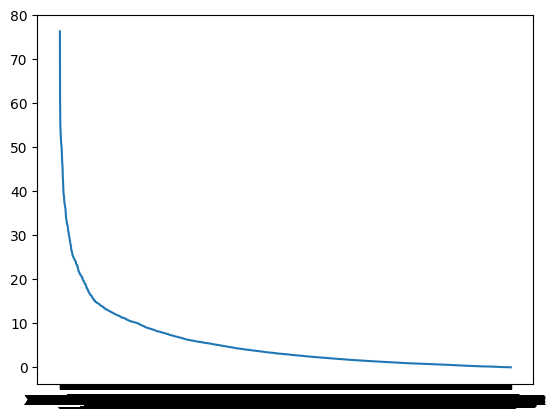

In [31]:
plt.plot(summary.sort_values('adjusted_score', ascending=False).index, summary.sort_values('adjusted_score', ascending=False)['adjusted_score'])

In [ ]:
# Load selected features
selected_features = DataLoader(dataPath, 'selected_features6.json')

In [56]:
# Build features from the list of selected features
featureLagBuilder = FeatureLagSelector(selected_features)
X = featureLagBuilder.fit_transform(features_group1)

In [57]:
# Delete not needed variables
del features_group1
del correlation_results_df
del summary
del correlation_analyzer
del featureLagBuilder
del correlation_in_bacthes
del results
del dict_results
gc.collect()

431

In [60]:
# Standardize X
X = FeatureGenerator(X).standardize_df()

In [ ]:
# Cluster features
cluster_analyzer = ClusterAnalyzer(X)
best_k, best_score, results = cluster_analyzer.optimal_number_of_clusters(50)

In [ ]:
# Develop features from qty_vol
# Modified group2: imbalance, buy_sell_ratio, volume_z
features_group2 = FeatureGenerator(features_group2).develop_features_from_qty_volume()

In [ ]:
# Lag modified group2
lagger = LagCreator()
features_group2 = lagger.lag_features(features_group2)

In [ ]:
# Standardize lagged group2 features
features_group2 = FeatureGenerator(features_group2).standardize_df()

In [51]:
print(selected_features)

['X264', 'X291', 'X264_lag1', 'X291_lag1', 'X291_lag2', 'X283_lag4', 'X283_lag5', 'X283_lag3', 'X283_lag2', 'X285_lag5', 'X283_lag1', 'X264_lag2', 'X285_lag4', 'X283', 'X291_lag5', 'X219_lag5', 'X291_lag3', 'X219_lag4', 'X219_lag3', 'X285_lag3', 'X219_lag2', 'X219_lag1', 'X219', 'X281_lag5', 'X285_lag2', 'X264_lag3', 'X285', 'X285_lag1', 'X291_lag4', 'X862_lag5', 'X281_lag4', 'X284', 'X862_lag4', 'X264_lag4', 'X865_lag5', 'X281_lag3', 'X282', 'X862_lag3', 'X865_lag4', 'X281_lag2', 'X862_lag2', 'X280_lag5', 'X343_lag5', 'X284_lag1', 'X264_lag5', 'X281_lag1', 'X281', 'X862_lag1', 'X280_lag4', 'X432_lag4', 'X865_lag3', 'X432_lag5', 'X862', 'X432_lag3', 'X438_lag5', 'X343_lag4', 'X288', 'X288_lag1', 'X284_lag2', 'X280_lag3', 'X288_lag2', 'X282_lag1', 'X416', 'X432_lag1', 'X343_lag3', 'X432_lag2', 'X416_lag1', 'X288_lag3', 'X438_lag4', 'X416_lag2', 'X865_lag2', 'X343_lag2', 'X284_lag5', 'X284_lag3', 'X272_lag5', 'X282_lag5', 'X432', 'X288_lag4', 'X280_lag2', 'X272_lag4', 'X343_lag1', 'X185_